In [1]:
# import necessary library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
import yfinance as yf
from datetime import datetime, timedelta

In [2]:
# income_statement_file = "Profit&Loss.csv"
pfizer_file = 'pfizer_data.csv'
df = pd.read_csv(pfizer_file)

print(f'Original Data Shape: {df.shape}')

# Data cleaning by dropping NaN
df = df.dropna(thresh=1)
df = df.dropna(axis=1)

# Set first column as index
df = df.set_index("Release Date")

Original Data Shape: (100, 29)


In [3]:
df

,Cash & Cash Equivalents,Marketable Securities,Receivables,Inventories,Income taxes - deferred,Other current assets,TOTAL,PPE Net,Investments And Advances,Intangibles,...,Accounts payable and accrued liabilities,Accrued Expenses,Other current liabilities,TOTAL.2,Long Term Debt,Deferred Revenues,Other Non-Current Liabilities,TOTAL.3,Total Liabilities,"Shares Outstanding, K"
Release Date,,,,,,,,,,,,,,,,,,,,,
31-Jan-23,416000,22316000,10952000,8981000,3577000,5017000,51259000,16274000,15069000,94745000,...,6809000,3407000,22568000,42138000,32884000,2520000,25234000,59149000,101288000,5619075
1-Nov-22,1298000,34825000,16076000,9513000,2544000,6147000,70403000,15441000,13888000,77592000,...,6267000,2852000,19647000,44314000,32629000,6191000,24885000,58145000,102459000,5613315
28-Jul-22,1780000,31524000,15155000,10454000,2583000,5970000,67466000,15244000,18962000,78956000,...,6208000,1997000,23816000,47410000,34294000,3804000,25552000,60410000,107821000,5612352
3-May-22,2470000,21427000,13225000,9979000,3117000,4202000,54420000,15109000,20737000,80027000,...,5506000,2249000,24583000,39268000,35656000,3108000,25570000,61887000,101155000,5610896
8-Feb-22,1944000,29125000,11479000,9059000,4266000,3820000,59693000,14882000,21526000,74354000,...,5578000,3332000,24939000,42671000,36195000,3067000,24800000,61342000,104013000,5623347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15-Apr-99,1166000,3039000,3470000,1704000,1370000,10749000,1548000,2197000,10769000,19025000,...,7752000,525000,1539000,2228000,9980000,71000,12254000,-4574000,9045000,19025000
19-Jan-99,1552000,2377000,2914000,1828000,1260000,9931000,1756000,2200000,3956000,18302000,...,7192000,527000,1576000,2300000,9492000,70000,11439000,-4434000,8810000,18302000
13-Oct-98,2723000,930000,2860000,1681000,1680000,9874000,1717000,2471000,10574000,18177000,...,7259000,528000,1304000,2273000,9532000,70000,11325000,-4061000,8645000,18177000


In [4]:
# Removed all columns having all 0s
df = df.drop(df.columns[df.eq(0).all()], axis=1)

# Force data column data to be numeric by removing comma
df = df.replace(',', '', regex=True)
df = df.apply(pd.to_numeric)

print(f'Cleaned Data Shape: {df.shape}')

Cleaned Data Shape: (100, 23)


In [5]:
# Calculate the correlation matrix
corr_matrix = df.corr().abs()

# Set the threshold
threshold = 0.99

# Identify highly correlated features
high_corr_features = np.where(corr_matrix > threshold)

# Remove highly correlated features
high_corr_features = []
for x, y in zip(*high_corr_features): 
    if x != y and x < y:
        col_x_y = (corr_matrix.columns[x], corr_matrix.columns[y]) 
        high_corr_features.append(col_x_y)
        
for feature in high_corr_features:
    df.drop(feature[1], axis=1 ,inplace=True ,errors='ignore')

print(f'Uncorelated Data Shape: {df.shape}')    

Uncorelated Data Shape: (100, 23)


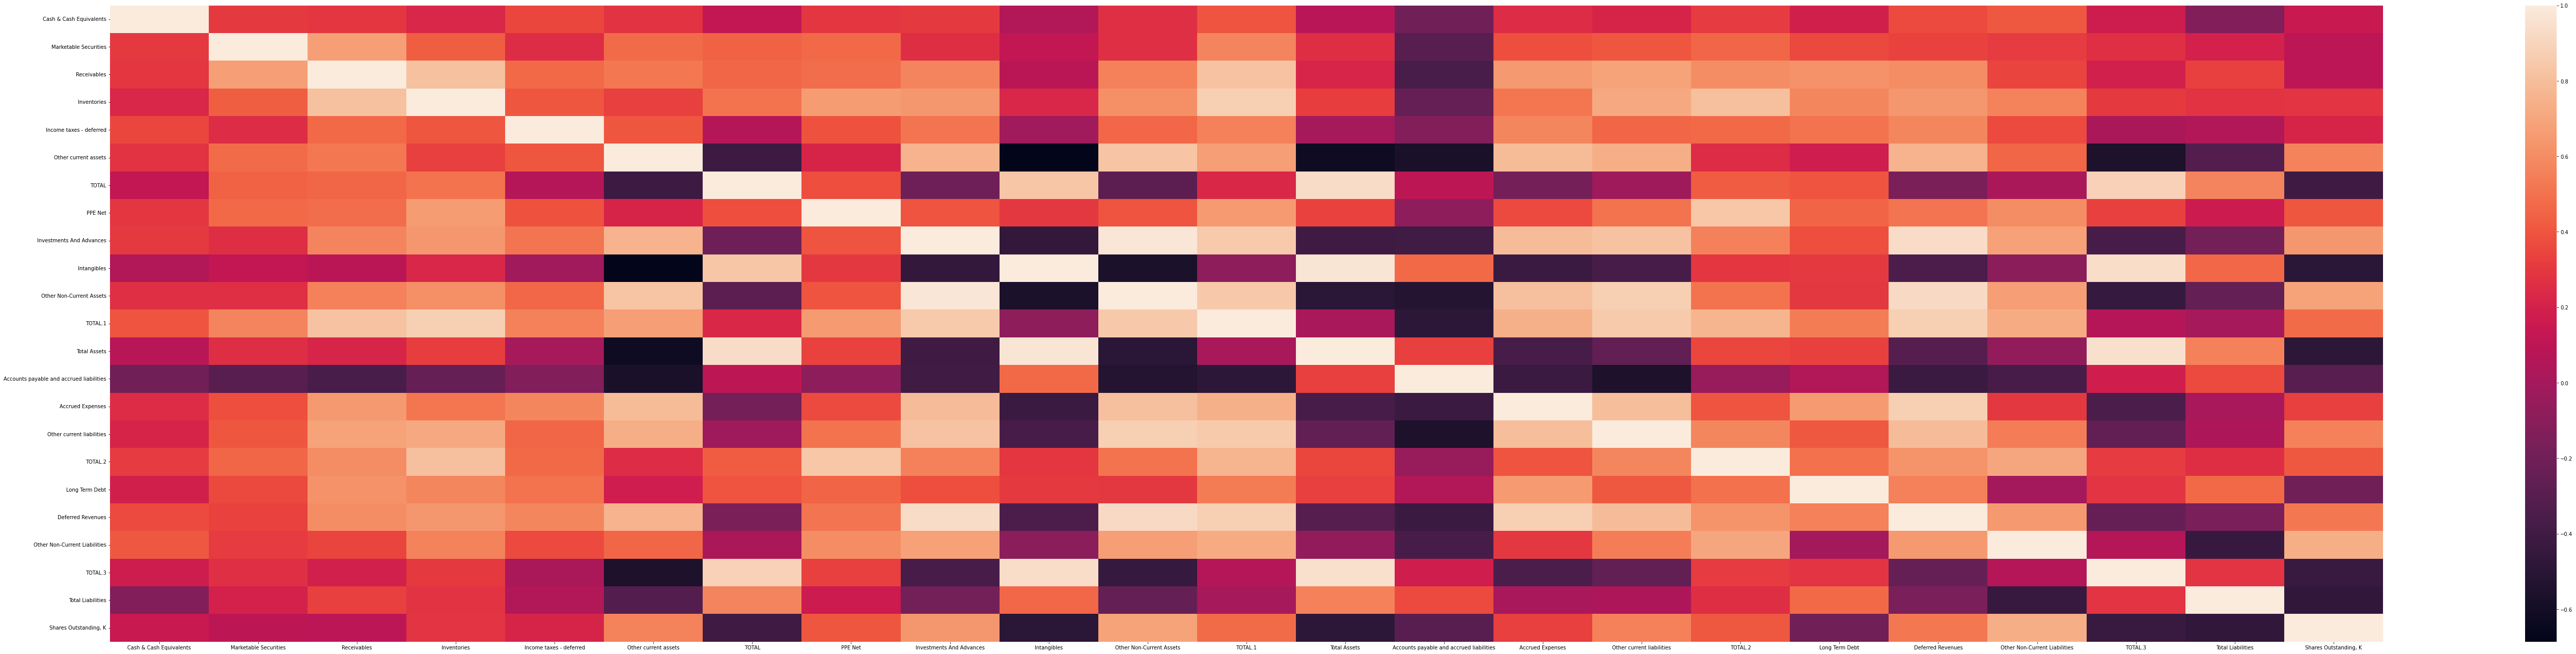

In [7]:
plt.rcParams['figure.figsize'] = df.shape
sns.heatmap(df.corr())
plt.show()

In [8]:

def get_last_day_price(symbol, date):
    start_date = datetime.strptime(date, '%d-%b-%y')
    end_date = start_date + timedelta(days=1)
    stock = yf.download(symbol, start=start_date, end=end_date, progress=False)
    last_day_price = stock.iloc[-1]
    price_diff = last_day_price['Close'] - last_day_price['Open']
    return price_diff

def get_price(df, symbol):
    df_index = df.index.to_list()
    price_dict = {}
    for i in df_index:
        price_dict[i] = get_last_day_price(symbol, i)
    y_df = pd.DataFrame.from_dict(price_dict, orient='index', columns=['Price'])
    y_df.index.name = 'Release Date'
    return y_df
    

In [9]:
symbol = 'PFE' # Pfizer, NYSE
ydf = get_price(df, symbol)

market = '^IXIC' # NASDAQ Composite, NYSE
market = get_price(df, market)

df = pd.concat([df, market], axis=1)

In [10]:
ydf

,Price
Release Date,
31-Jan-23,1.160000
1-Nov-22,0.009998
28-Jul-22,-0.129997
3-May-22,0.420002
8-Feb-22,1.060001
...,...
15-Apr-99,-3.795067
19-Jan-99,-0.553448
13-Oct-98,-2.055660


In [13]:
x, y = df, ydf

x_train, x_test, y_train, y_test = train_test_split(x, y)

# Fitting Simple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(x_train, y_train)

# Predicting the Test & Train set results
y_test_pred = regressor.predict(x_test)
y_train_pred = regressor.predict(x_train)

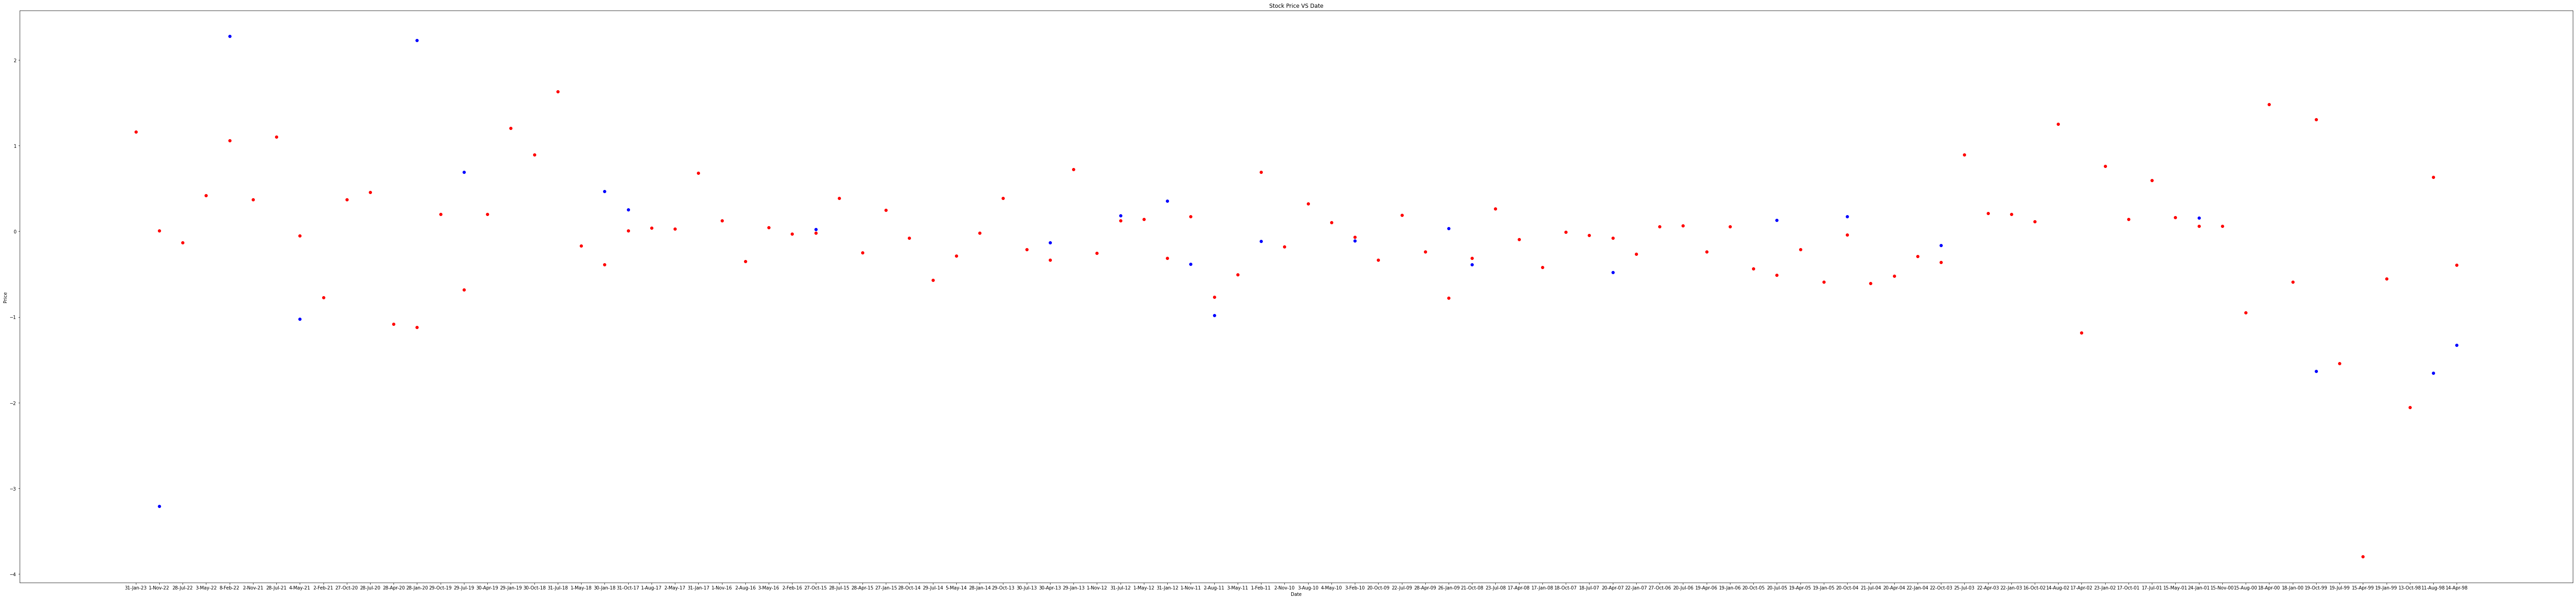

<Figure size 576x288 with 0 Axes>

In [18]:
# Visualizing the Training set results
viz_train = plt
viz_train.scatter(x.index, y, color='red')
viz_train.scatter(x_test.index, y_test_pred, color='blue')
viz_train.title('Stock Price VS Date')
viz_train.xlabel('Date')
viz_train.ylabel('Price')
viz_train.figure(figsize=(8, 4))
viz_train.show() # Note: Image generated are zoomed out, double click to get zoomed in figure